# Prosper loans dataset Investigation
## by Ahmed Metwalli

## Investigation Overview

In this investigation, there are two key points to be taken into account:
<ul>
    <li>Which features can predict default on credit.</li>
    <li>Which features is ,actually, influencing 'ProsperRating (Alpha)'.</li>
</ul>

## Dataset Overview

Data set provided with shape of <b>[113937,81]</b> this means 133937 loans and 81 features. For this investigation, these features are taken into account: <b> Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate, Recommendations, Investors </b>.
After the wrangling process <b>(Gather, Assess and Clean)</b>, there are <b>26005</b> data points are extracted to be used during the investigation.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# setting default color
default_color = sb.color_palette('muted')[0]
# getting rid of scientific notation
pd.options.display.float_format = '{:.2f}'.format

## Wrangling Phase
The issues are as follows:
<ol>
    <li>Prosper has used ProsperRating (Alpha) since 2009 ,unlike before, when Prosper had used credit grade. As a conseuqence I just kept the data since 2009</li>
    <li>A tidiness issue is that most of the loans in dataset are current loans and doesn't give information on how default on credit can be predicted. 'Defaulted' credits were represented in two categries 'Chargedoff and 'Defaulted'. A quick solve for this issue is done which is to remove all the current loans and merge 'Chargedoff' with 'Defaulted' credits.</li>
    <li>'StatedMonthlyIncome' features had 2 main problems:  Many outliers and very large range out of the triple of the standard deviation from the mean. Obviously, it is solved by dropping the out of range (out of triple the standard deviation).</li>
</ol>

In [4]:
#We only want the data after 2009. Hence, the data to be dropped are the NaN in ['ProsperRating (Alpha))']
target_df = df.dropna(subset=['ProsperRating (Alpha)']).reset_index()

In [5]:
target_df['StatedMonthlyIncome'].describe()

count     84853.00
mean       5931.17
std        8239.94
min           0.00
25%        3434.00
50%        5000.00
75%        7083.33
max     1750002.92
Name: StatedMonthlyIncome, dtype: float64

In [6]:
#Defining the boundary to solve the problem of the very large range in StatedMonthlyIncome
income_std = target_df['StatedMonthlyIncome'].std()
income_mean = target_df['StatedMonthlyIncome'].mean()
boundary = income_mean + income_std * 3
boundary

30651.006023351034

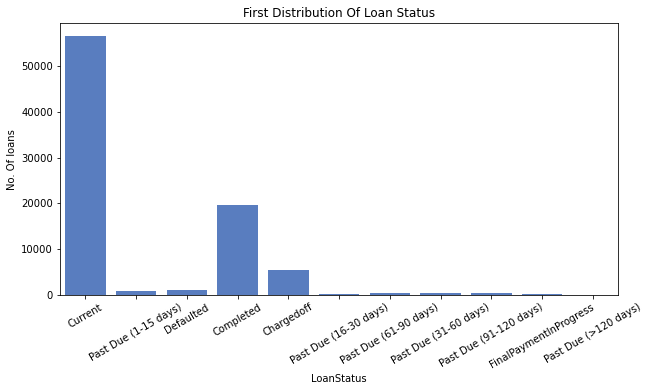

In [7]:
plt.figure(figsize=[10, 5])
plt.xticks(rotation=30)
plt.title('First Distribution Of Loan Status')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color)
plt.ylabel('No. Of loans');

In [8]:
# Solving the problem of tidiness (combining or merging and leaving only completed chargedoff or defaulted listings)
condition = (target_df['LoanStatus'] == 'Completed') | (target_df['LoanStatus'] == 'Defaulted') | (target_df['LoanStatus'] == 'Chargedoff')
target_df = target_df[condition]
# Make chargedoff as defaulted
def change_to_defaulted(row):
    if row['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return row['LoanStatus']

target_df['LoanStatus'] = target_df.apply(change_to_defaulted, axis=1)

During the wrangling phase we extracted <b>26005</b> loans from the data of which we have <b>19664 'Completed' loans and 6341 'Defaulted'.

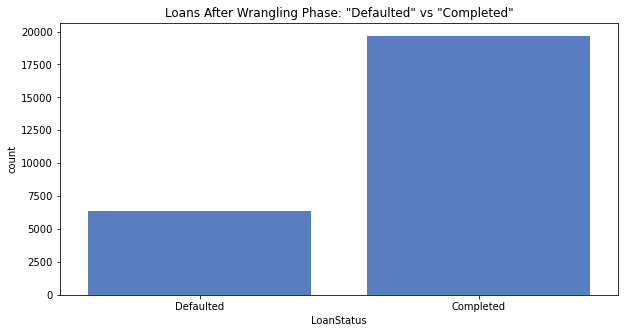

In [9]:
plt.figure(figsize=[10, 5])
plt.title('Loans After Wrangling Phase: "Defaulted" vs "Completed"')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color);

In [10]:
# Completing wrangling for StatedMonthlyIncome we have to remove outliers that are out of range
target_df = target_df[target_df['StatedMonthlyIncome'] < boundary]

In the end, after the wrangling process, we notice that the shape of 'StatedMonthlyIncome' looks like if it is normally distributed with high right skewness and a mean of <b>5328 USD</b> with a maximum of <b>30416.67 USD</b>.

In [11]:
target_df['StatedMonthlyIncome'].describe()

count   25938.00
mean     5328.39
std      3390.76
min         0.00
25%      3166.67
50%      4583.33
75%      6666.67
max     30416.67
Name: StatedMonthlyIncome, dtype: float64

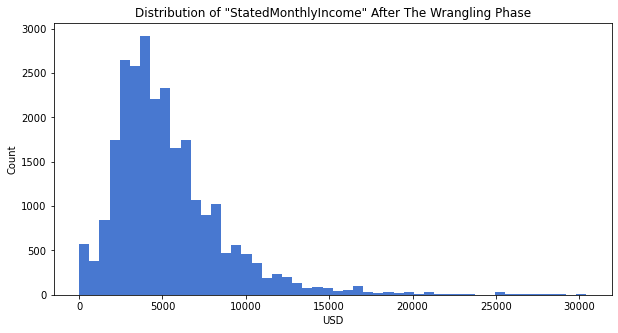

In [12]:
plt.figure(figsize=[10, 5])
plt.title('Distribution of "StatedMonthlyIncome" After The Wrangling Phase')
plt.ylabel('Count')
plt.xlabel('USD')
plt.hist(data=target_df, x='StatedMonthlyIncome', bins=50, color=default_color);

From data dictionary we find that, 'ProsperRating (Alpha)' is an ordinal categorical variable with the following values from the highest to lowest ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']. This feature 'ProsperRating (Alpha)' has almost normal distribution of which the data is centered on 'C'and (the edges 'AA' and 'HR') are less likely to occur. 

In [13]:
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
df['ProsperRating (Alpha)'] = df['ProsperRating (Alpha)'].astype(ordered_var)

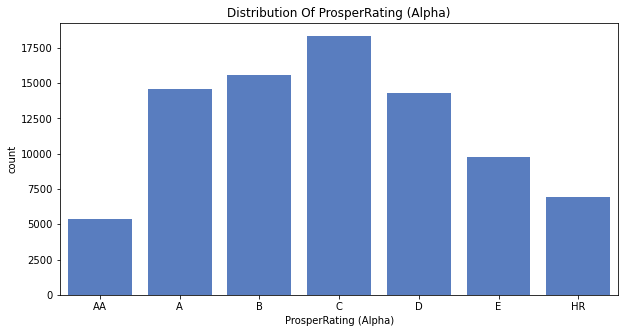

In [14]:
plt.figure(figsize=[10, 5])
plt.title('Distribution Of ProsperRating (Alpha)')
sb.countplot(data=df, x='ProsperRating (Alpha)', color=default_color);

In [15]:
# Wrangling Phase for categorical variables
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
target_df['ProsperRating (Alpha)'] = target_df['ProsperRating (Alpha)'].astype(ordered_var)

categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 6: 'Auto', 7: 'Other'}
def reduce_categories(row):
    loan_category = row['ListingCategory (numeric)']
    if  loan_category in categories:
        return categories[loan_category]
    else:
        return categories[7]

target_df['ListingCategory (numeric)'] = target_df.apply(reduce_categories, axis=1)

Generally, it is noticeable that the more there are defaults on credits came from the lower the 'ProsperRating (Alpha)', but rating <b>D</b> is an exception as it  tends to be the most frequent rating among defaulted credits. 

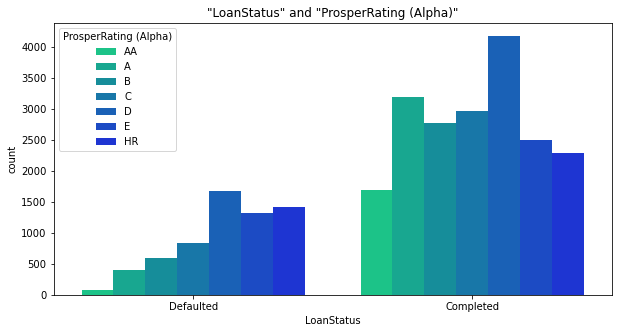

In [16]:
plt.figure(figsize=[10, 5])
plt.title('"LoanStatus" and "ProsperRating (Alpha)"')
sb.countplot(data=target_df, x='LoanStatus', hue='ProsperRating (Alpha)', palette='winter_r');

Employment status 'Not employed' or 'Self-employed' for individuals, are more likely to have default on credit.

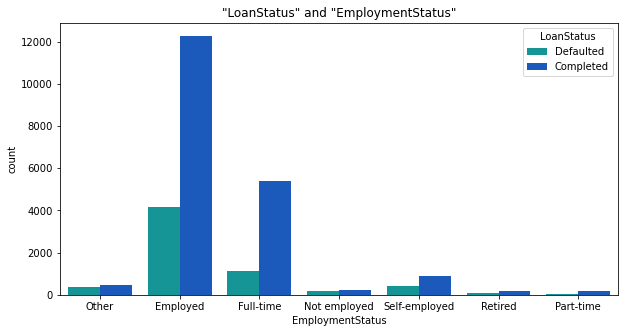

In [17]:
plt.figure(figsize = [10, 5])
plt.title('"LoanStatus" and "EmploymentStatus"')
sb.countplot(data=target_df, x='EmploymentStatus', hue='LoanStatus', palette='winter_r');

The long-term loans (60 months) have the greatest proportion of defaulted credits.

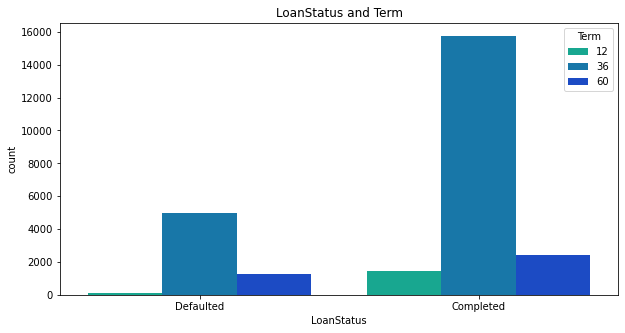

In [18]:
plt.figure(figsize = [10, 5])
plt.title('LoanStatus and Term')
sb.countplot(data=target_df, x='LoanStatus', hue='Term', palette='winter_r');

It is predictable that borrowers of high 'ProsperRating (Alpha)' will borrow more. In addition to, 'Defaulted' loans looks like to be larger than 'Completed' for high 'ProsperRating (Alpha)' borrowers. On the other hand, low 'ProsperRating (Alpha)' borrowers, we can safely say that, they borrow less and their defaulted credits, usually, as big as completed.

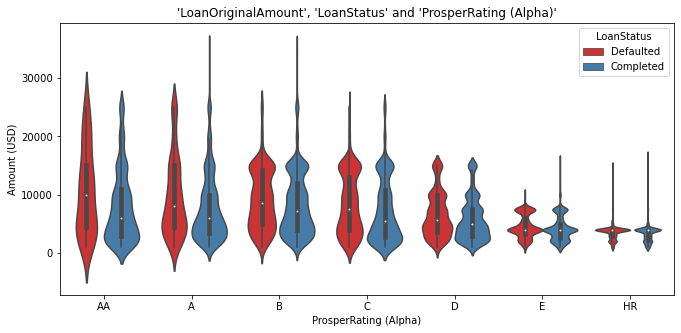

In [19]:
plt.figure(figsize = [11, 5])
plt.title("'LoanOriginalAmount', 'LoanStatus' and 'ProsperRating (Alpha)'")
sb.violinplot(data=target_df, x='ProsperRating (Alpha)', y='LoanOriginalAmount', hue='LoanStatus', palette="Set1")
plt.xlabel('ProsperRating (Alpha)')
plt.ylabel('Amount (USD)');

Also we can safely say that, 'Business' and 'Home Improvement' categories are the riskiest.

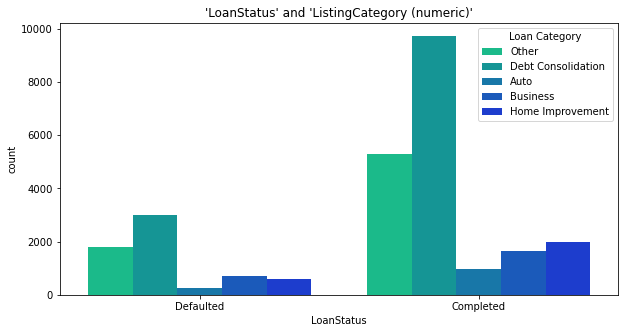

In [20]:
plt.figure(figsize = [10, 5])
plt.title("'LoanStatus' and 'ListingCategory (numeric)'")
g = sb.countplot(data=target_df, x='LoanStatus', hue='ListingCategory (numeric)', palette='winter_r')
g.legend_.set_title('Loan Category')

It can be witnessed that, higher 'StatedMonthlyIncome' came from individuals with high 'ProsperRating (Alpha)'.

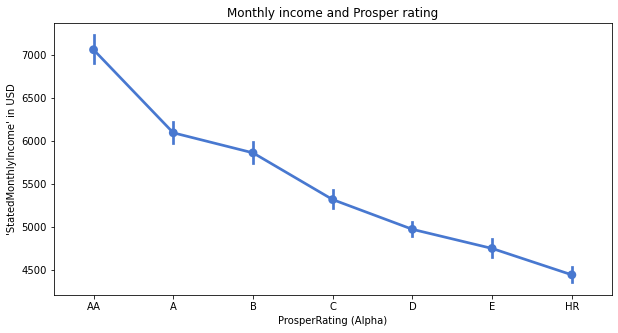

In [21]:
plt.figure(figsize = [10, 5])
plt.title('Monthly income and Prosper rating')
sb.pointplot(data = target_df, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', linestyles = '-', color = default_color)
plt.xlabel('ProsperRating (Alpha)')
plt.ylabel("'StatedMonthlyIncome' in USD");

'EmploymentStatus' with individuals ['Not employed', 'Self-employed', 'Retired'] are having lower 'ProsperRating (Alpha)'.

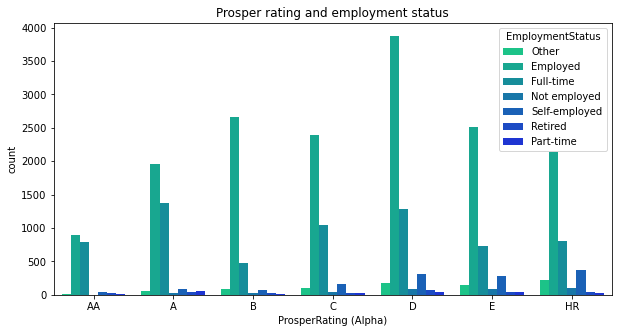

In [22]:
plt.figure(figsize = [10, 5])
plt.title('Prosper rating and employment status')
sb.countplot(data = target_df, x = 'ProsperRating (Alpha)', hue = 'EmploymentStatus', palette='winter_r');

In [ ]:
!jupyter nbconvert slide_deck --to slides --post serve  --no-input --no-prompt